## MMD ResNet for RNA data - Log transformed

Use GTEX as source and TCGA as target since there are 2445 GTEX samples and only 683 TCGA samples

### Imports

In [1]:
import os.path
import keras.optimizers
from Calibration_Util import DataHandler as dh 
from Calibration_Util import FileIO as io
from keras.layers import Input, Dense, merge, Activation, add
from keras.models import Model
from keras import callbacks as cb
import numpy as np
import matplotlib
from keras.layers.normalization import BatchNormalization
#detect display
import os
havedisplay = "DISPLAY" in os.environ
#if we have a display use a plotting backend
if havedisplay:
    matplotlib.use('TkAgg')
else:
    matplotlib.use('Agg')

import CostFunctions as cf
import Monitoring as mn
from keras.regularizers import l2
from sklearn import decomposition
from keras.callbacks import LearningRateScheduler
import math
import ScatterHist as sh
from keras import initializers
from numpy import genfromtxt
import sklearn.preprocessing as prep
import tensorflow as tf
import keras.backend as K

import pandas as pd

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Configure hyperparameters

In [2]:
mmdNetLayerSizes = [20, 20]
l2_penalty = 1e-2

### Load Data

In [3]:
# sourcePath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch1-gtex-20PCs.csv')
# targetPath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch2-tcga-20PCs.csv')

sourceFileName = 'unnorm-log-20PC-GTEX-breast-prostate-thyroid.csv'
targetFileName = 'unnorm-log-20PC-TCGA-breast-prostate-thyroid.csv'

sourcePath = os.path.join(io.DeepLearningRoot(), 'data/unnorm/' + sourceFileName)
targetPath = os.path.join(io.DeepLearningRoot(), 'data/unnorm/' + targetFileName)

In [4]:
# source = genfromtxt(sourcePath, delimiter=',', skip_header=1)
# target = genfromtxt(targetPath, delimiter=',', skip_header=1)

source = pd.read_csv(sourcePath, sep=',', header=0, index_col=0)
target = pd.read_csv(targetPath, sep=',', header=0, index_col=0)



In [5]:
source[["PC1", "PC2"]][0:4]

,PC1,PC2
GTEX.breast,-1047.593614,-69.125751
GTEX.breast.1,-999.462901,-48.396654
GTEX.breast.2,-1044.107343,-78.821058
GTEX.breast.3,-1060.326254,-69.966899


In [6]:
target[["PC1", "PC2"]][0:4]

,PC1,PC2
TCGA.breast,-1063.886554,-92.713602
TCGA.breast.1,-1016.555391,-76.951760
TCGA.breast.2,-1064.027776,-84.894844
TCGA.breast.3,-1037.386398,-88.541704


In [7]:
source = source.values
target = target.values

In [8]:
print(source[0:4, 0:2])
print(target[0:4, 0:2])

inputDim = target.shape[1]
print("inputDim = " + str(inputDim))

[[-1047.59361381   -69.12575067]
 [ -999.46290114   -48.39665354]
 [-1044.10734269   -78.82105825]
 [-1060.32625385   -69.96689896]]
[[-1063.88655395   -92.71360174]
 [-1016.55539065   -76.95176009]
 [-1064.02777643   -84.89484393]
 [-1037.38639806   -88.54170399]]
inputDim = 20


In [9]:
print("gtex = source shape = " + str(source.shape))
print("tcga = target shape = " + str(target.shape))

gtex = source shape = (636, 20)
tcga = target shape = (211, 20)


### Build MMD Net

In [10]:
# input
calibInput = Input(shape=(inputDim, ))

# block 1
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1)
block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2)
block1_output = add([block1_w2, calibInput])

# block 2
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1)
block2_bn2 = BatchNormalization()(block1_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2)
block2_output = add([block2_w2, calibInput])

# block 3
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1)
block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2)
block3_output = add([block3_w2, calibInput])

calibMMDNet = Model(inputs=calibInput, outputs=block3_output)

### Prepare for Training

In [11]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

# optimizer = keras.optimizers.rmsprop(lr=0.0)
optimizer = keras.optimizers.Adam()

calibMMDNet.compile(optimizer=optimizer, 
                    loss=lambda y_true,y_pred: 
                       cf.MMD(block3_output, target, MMDTargetValidation_split=0.1,
                             MMDTargetSampleSize=100, n_neighbors=10).KerasCost(y_true,y_pred)
                   )

K.get_session().run(tf.global_variables_initializer())

sourceLabels = np.zeros(source.shape)
sourceLabels.shape

setting scales using KNN
[24.283234066309433, 48.566468132618866, 97.132936265237731]
setting all scale weights to 1


(636, 20)

### Train

In [12]:
#calibMMDNet.fit(source, sourceLabels, epochs=500 ,batch_size=10, validation_split=0.1, verbose=1,
#               callbacks=[lrate, mn.monitorMMD(source, target, calibMMDNet.predict),
#                          cb.EarlyStopping(monitor='val_loss',patience=50,mode='auto')]
#               )

calibMMDNet.fit(source, sourceLabels, epochs=5000, batch_size=20, validation_split=0.1, verbose=1)

Train on 572 samples, validate on 64 samples
Epoch 1/5000
572/572 [==============================] - 1s 1ms/step - loss: 1.2691 - val_loss: 1.8092
Epoch 2/5000
572/572 [==============================] - 0s 487us/step - loss: 1.2625 - val_loss: 1.8094
Epoch 3/5000
572/572 [==============================] - 0s 492us/step - loss: 1.2604 - val_loss: 1.8095
Epoch 4/5000
572/572 [==============================] - 0s 494us/step - loss: 1.2665 - val_loss: 1.8094
Epoch 5/5000
572/572 [==============================] - 0s 495us/step - loss: 1.2676 - val_loss: 1.8093
Epoch 6/5000
572/572 [==============================] - 0s 485us/step - loss: 1.2679 - val_loss: 1.8092
Epoch 7/5000
572/572 [==============================] - 0s 498us/step - loss: 1.2672 - val_loss: 1.8091
Epoch 8/5000
572/572 [==============================] - 0s 490us/step - loss: 1.2583 - val_loss: 1.8090
Epoch 9/5000
572/572 [==============================] - 0s 495us/step - loss: 1.2583 - val_loss: 1.8088
Epoch 10/5000
572/572

572/572 [==============================] - 0s 568us/step - loss: 1.0259 - val_loss: 1.4770
Epoch 156/5000
572/572 [==============================] - 0s 568us/step - loss: 1.0288 - val_loss: 1.4780
Epoch 157/5000
572/572 [==============================] - 0s 501us/step - loss: 1.0327 - val_loss: 1.4779
Epoch 158/5000
572/572 [==============================] - 0s 488us/step - loss: 1.0292 - val_loss: 1.4738
Epoch 159/5000
572/572 [==============================] - 0s 497us/step - loss: 1.0360 - val_loss: 1.4731
Epoch 160/5000
572/572 [==============================] - 0s 489us/step - loss: 1.0260 - val_loss: 1.4742
Epoch 161/5000
572/572 [==============================] - 0s 493us/step - loss: 1.0248 - val_loss: 1.4766
Epoch 162/5000
572/572 [==============================] - 0s 497us/step - loss: 1.0288 - val_loss: 1.4769
Epoch 163/5000
572/572 [==============================] - 0s 500us/step - loss: 1.0248 - val_loss: 1.4749
Epoch 164/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 491us/step - loss: 0.9526 - val_loss: 1.4550
Epoch 310/5000
572/572 [==============================] - 0s 492us/step - loss: 0.9611 - val_loss: 1.4549
Epoch 311/5000
572/572 [==============================] - 0s 494us/step - loss: 0.9472 - val_loss: 1.4537
Epoch 312/5000
572/572 [==============================] - 0s 488us/step - loss: 0.9619 - val_loss: 1.4490
Epoch 313/5000
572/572 [==============================] - 0s 492us/step - loss: 0.9487 - val_loss: 1.4519
Epoch 314/5000
572/572 [==============================] - 0s 489us/step - loss: 0.9532 - val_loss: 1.4537
Epoch 315/5000
572/572 [==============================] - 0s 495us/step - loss: 0.9410 - val_loss: 1.4542
Epoch 316/5000
572/572 [==============================] - 0s 493us/step - loss: 0.9519 - val_loss: 1.4525
Epoch 317/5000
572/572 [==============================] - 0s 497us/step - loss: 0.9441 - val_loss: 1.4511
Epoch 318/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 491us/step - loss: 0.8979 - val_loss: 1.4731
Epoch 464/5000
572/572 [==============================] - 0s 494us/step - loss: 0.8983 - val_loss: 1.4659
Epoch 465/5000
572/572 [==============================] - 0s 493us/step - loss: 0.9122 - val_loss: 1.4591
Epoch 466/5000
572/572 [==============================] - 0s 490us/step - loss: 0.9034 - val_loss: 1.4677
Epoch 467/5000
572/572 [==============================] - 0s 490us/step - loss: 0.9054 - val_loss: 1.4600
Epoch 468/5000
572/572 [==============================] - 0s 502us/step - loss: 0.8957 - val_loss: 1.4566
Epoch 469/5000
572/572 [==============================] - 0s 489us/step - loss: 0.9070 - val_loss: 1.4516
Epoch 470/5000
572/572 [==============================] - 0s 494us/step - loss: 0.8924 - val_loss: 1.4617
Epoch 471/5000
572/572 [==============================] - 0s 494us/step - loss: 0.8907 - val_loss: 1.4691
Epoch 472/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 499us/step - loss: 0.8745 - val_loss: 1.4412
Epoch 618/5000
572/572 [==============================] - 0s 500us/step - loss: 0.8843 - val_loss: 1.4511
Epoch 619/5000
572/572 [==============================] - 0s 493us/step - loss: 0.8665 - val_loss: 1.4487
Epoch 620/5000
572/572 [==============================] - 0s 493us/step - loss: 0.8848 - val_loss: 1.4390
Epoch 621/5000
572/572 [==============================] - 0s 497us/step - loss: 0.8674 - val_loss: 1.4413
Epoch 622/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8757 - val_loss: 1.4412
Epoch 623/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8842 - val_loss: 1.4431
Epoch 624/5000
572/572 [==============================] - 0s 499us/step - loss: 0.8854 - val_loss: 1.4459
Epoch 625/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8927 - val_loss: 1.4368
Epoch 626/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 494us/step - loss: 0.8616 - val_loss: 1.4161
Epoch 772/5000
572/572 [==============================] - 0s 482us/step - loss: 0.8530 - val_loss: 1.4316
Epoch 773/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8630 - val_loss: 1.4194
Epoch 774/5000
572/572 [==============================] - 0s 487us/step - loss: 0.8574 - val_loss: 1.4219
Epoch 775/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8450 - val_loss: 1.4233
Epoch 776/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8630 - val_loss: 1.4352
Epoch 777/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8617 - val_loss: 1.4179
Epoch 778/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8745 - val_loss: 1.4249
Epoch 779/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8591 - val_loss: 1.4224
Epoch 780/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 490us/step - loss: 0.8367 - val_loss: 1.4117
Epoch 926/5000
572/572 [==============================] - 0s 486us/step - loss: 0.8490 - val_loss: 1.4085
Epoch 927/5000
572/572 [==============================] - 0s 497us/step - loss: 0.8390 - val_loss: 1.4103
Epoch 928/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8471 - val_loss: 1.4151
Epoch 929/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8398 - val_loss: 1.4149
Epoch 930/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8326 - val_loss: 1.4139
Epoch 931/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8290 - val_loss: 1.4154
Epoch 932/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8307 - val_loss: 1.4257
Epoch 933/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8353 - val_loss: 1.4238
Epoch 934/5000
572/572 [==============================] - 0s 

572/572 [==============================] - 0s 492us/step - loss: 0.8387 - val_loss: 1.4043
Epoch 1079/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8371 - val_loss: 1.4166
Epoch 1080/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8271 - val_loss: 1.4089
Epoch 1081/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8361 - val_loss: 1.3961
Epoch 1082/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8191 - val_loss: 1.3986
Epoch 1083/5000
572/572 [==============================] - 0s 484us/step - loss: 0.8444 - val_loss: 1.4074
Epoch 1084/5000
572/572 [==============================] - 0s 483us/step - loss: 0.8461 - val_loss: 1.4030
Epoch 1085/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8254 - val_loss: 1.4085
Epoch 1086/5000
572/572 [==============================] - 0s 487us/step - loss: 0.8276 - val_loss: 1.4031
Epoch 1087/5000
572/572 [============================

572/572 [==============================] - 0s 490us/step - loss: 0.8432 - val_loss: 1.3951
Epoch 1231/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8133 - val_loss: 1.4110
Epoch 1232/5000
572/572 [==============================] - 0s 498us/step - loss: 0.8234 - val_loss: 1.4183
Epoch 1233/5000
572/572 [==============================] - 0s 497us/step - loss: 0.8205 - val_loss: 1.3843
Epoch 1234/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8368 - val_loss: 1.3834
Epoch 1235/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8303 - val_loss: 1.3869
Epoch 1236/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8276 - val_loss: 1.3851
Epoch 1237/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8188 - val_loss: 1.3826
Epoch 1238/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8308 - val_loss: 1.3855
Epoch 1239/5000
572/572 [============================

572/572 [==============================] - 0s 484us/step - loss: 0.8118 - val_loss: 1.3841
Epoch 1383/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8269 - val_loss: 1.3801
Epoch 1384/5000
572/572 [==============================] - 0s 485us/step - loss: 0.8297 - val_loss: 1.3827
Epoch 1385/5000
572/572 [==============================] - 0s 485us/step - loss: 0.8135 - val_loss: 1.3752
Epoch 1386/5000
572/572 [==============================] - 0s 487us/step - loss: 0.8292 - val_loss: 1.3774
Epoch 1387/5000
572/572 [==============================] - 0s 485us/step - loss: 0.8228 - val_loss: 1.3792
Epoch 1388/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8095 - val_loss: 1.3890
Epoch 1389/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8284 - val_loss: 1.3850
Epoch 1390/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8278 - val_loss: 1.3846
Epoch 1391/5000
572/572 [============================

572/572 [==============================] - 0s 490us/step - loss: 0.8186 - val_loss: 1.3746
Epoch 1535/5000
572/572 [==============================] - 0s 485us/step - loss: 0.8168 - val_loss: 1.3908
Epoch 1536/5000
572/572 [==============================] - 0s 493us/step - loss: 0.8131 - val_loss: 1.3725
Epoch 1537/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8190 - val_loss: 1.3833
Epoch 1538/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8131 - val_loss: 1.3678
Epoch 1539/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8157 - val_loss: 1.3764
Epoch 1540/5000
572/572 [==============================] - 0s 482us/step - loss: 0.8182 - val_loss: 1.3754
Epoch 1541/5000
572/572 [==============================] - 0s 487us/step - loss: 0.8061 - val_loss: 1.3828
Epoch 1542/5000
572/572 [==============================] - 0s 486us/step - loss: 0.8259 - val_loss: 1.3875
Epoch 1543/5000
572/572 [============================

572/572 [==============================] - 0s 491us/step - loss: 0.8059 - val_loss: 1.3624
Epoch 1687/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8159 - val_loss: 1.3704
Epoch 1688/5000
572/572 [==============================] - 0s 483us/step - loss: 0.8129 - val_loss: 1.3946
Epoch 1689/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8149 - val_loss: 1.3797
Epoch 1690/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8250 - val_loss: 1.3928
Epoch 1691/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8107 - val_loss: 1.4075
Epoch 1692/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8111 - val_loss: 1.3837
Epoch 1693/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8074 - val_loss: 1.3775
Epoch 1694/5000
572/572 [==============================] - 0s 496us/step - loss: 0.8098 - val_loss: 1.3635
Epoch 1695/5000
572/572 [============================

572/572 [==============================] - 0s 480us/step - loss: 0.8151 - val_loss: 1.3832
Epoch 1839/5000
572/572 [==============================] - 0s 486us/step - loss: 0.8161 - val_loss: 1.3685
Epoch 1840/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8000 - val_loss: 1.3748
Epoch 1841/5000
572/572 [==============================] - 0s 494us/step - loss: 0.8192 - val_loss: 1.3661
Epoch 1842/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7999 - val_loss: 1.3600
Epoch 1843/5000
572/572 [==============================] - 0s 482us/step - loss: 0.8123 - val_loss: 1.3706
Epoch 1844/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8056 - val_loss: 1.3700
Epoch 1845/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8057 - val_loss: 1.3891
Epoch 1846/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8127 - val_loss: 1.3838
Epoch 1847/5000
572/572 [============================

572/572 [==============================] - 0s 490us/step - loss: 0.8138 - val_loss: 1.3638
Epoch 1991/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8098 - val_loss: 1.3523
Epoch 1992/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8072 - val_loss: 1.3594
Epoch 1993/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8072 - val_loss: 1.3586
Epoch 1994/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7866 - val_loss: 1.3575
Epoch 1995/5000
572/572 [==============================] - 0s 481us/step - loss: 0.8149 - val_loss: 1.3465
Epoch 1996/5000
572/572 [==============================] - 0s 483us/step - loss: 0.8174 - val_loss: 1.3606
Epoch 1997/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8225 - val_loss: 1.3644
Epoch 1998/5000
572/572 [==============================] - 0s 483us/step - loss: 0.8031 - val_loss: 1.3676
Epoch 1999/5000
572/572 [============================

572/572 [==============================] - 0s 489us/step - loss: 0.7970 - val_loss: 1.3594
Epoch 2143/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8227 - val_loss: 1.3535
Epoch 2144/5000
572/572 [==============================] - 0s 494us/step - loss: 0.7858 - val_loss: 1.3535
Epoch 2145/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8097 - val_loss: 1.3534
Epoch 2146/5000
572/572 [==============================] - 0s 485us/step - loss: 0.8010 - val_loss: 1.3513
Epoch 2147/5000
572/572 [==============================] - 0s 483us/step - loss: 0.8188 - val_loss: 1.3449
Epoch 2148/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8122 - val_loss: 1.3574
Epoch 2149/5000
572/572 [==============================] - 0s 498us/step - loss: 0.8133 - val_loss: 1.3627
Epoch 2150/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7985 - val_loss: 1.3569
Epoch 2151/5000
572/572 [============================

572/572 [==============================] - 0s 486us/step - loss: 0.8065 - val_loss: 1.3430
Epoch 2295/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8108 - val_loss: 1.3579
Epoch 2296/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8019 - val_loss: 1.3599
Epoch 2297/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7967 - val_loss: 1.3598
Epoch 2298/5000
572/572 [==============================] - 0s 483us/step - loss: 0.7990 - val_loss: 1.3497
Epoch 2299/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7928 - val_loss: 1.3422
Epoch 2300/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7926 - val_loss: 1.3530
Epoch 2301/5000
572/572 [==============================] - 0s 494us/step - loss: 0.8022 - val_loss: 1.3530
Epoch 2302/5000
572/572 [==============================] - 0s 484us/step - loss: 0.8005 - val_loss: 1.3381
Epoch 2303/5000
572/572 [============================

572/572 [==============================] - 0s 483us/step - loss: 0.8107 - val_loss: 1.3493
Epoch 2447/5000
572/572 [==============================] - 0s 481us/step - loss: 0.8024 - val_loss: 1.3643
Epoch 2448/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7877 - val_loss: 1.3743
Epoch 2449/5000
572/572 [==============================] - 0s 485us/step - loss: 0.8026 - val_loss: 1.3446
Epoch 2450/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7934 - val_loss: 1.3512
Epoch 2451/5000
572/572 [==============================] - 0s 483us/step - loss: 0.8011 - val_loss: 1.3472
Epoch 2452/5000
572/572 [==============================] - 0s 484us/step - loss: 0.8002 - val_loss: 1.3460
Epoch 2453/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8031 - val_loss: 1.3538
Epoch 2454/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8063 - val_loss: 1.3586
Epoch 2455/5000
572/572 [============================

572/572 [==============================] - 0s 487us/step - loss: 0.7983 - val_loss: 1.3455
Epoch 2599/5000
572/572 [==============================] - 0s 491us/step - loss: 0.7994 - val_loss: 1.3344
Epoch 2600/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7745 - val_loss: 1.3498
Epoch 2601/5000
572/572 [==============================] - 0s 486us/step - loss: 0.8339 - val_loss: 1.3414
Epoch 2602/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7894 - val_loss: 1.3374
Epoch 2603/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8010 - val_loss: 1.3327
Epoch 2604/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7999 - val_loss: 1.3570
Epoch 2605/5000
572/572 [==============================] - 0s 490us/step - loss: 0.8004 - val_loss: 1.3365
Epoch 2606/5000
572/572 [==============================] - 0s 484us/step - loss: 0.8059 - val_loss: 1.3391
Epoch 2607/5000
572/572 [============================

572/572 [==============================] - 0s 487us/step - loss: 0.7902 - val_loss: 1.3383
Epoch 2751/5000
572/572 [==============================] - 0s 491us/step - loss: 0.8156 - val_loss: 1.3446
Epoch 2752/5000
572/572 [==============================] - 0s 482us/step - loss: 0.7941 - val_loss: 1.3561
Epoch 2753/5000
572/572 [==============================] - 0s 487us/step - loss: 0.8109 - val_loss: 1.3496
Epoch 2754/5000
572/572 [==============================] - 0s 488us/step - loss: 0.8000 - val_loss: 1.3648
Epoch 2755/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7894 - val_loss: 1.3658
Epoch 2756/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7815 - val_loss: 1.3586
Epoch 2757/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7933 - val_loss: 1.3763
Epoch 2758/5000
572/572 [==============================] - 0s 479us/step - loss: 0.7964 - val_loss: 1.3717
Epoch 2759/5000
572/572 [============================

572/572 [==============================] - 0s 488us/step - loss: 0.7896 - val_loss: 1.3697
Epoch 2903/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7996 - val_loss: 1.3603
Epoch 2904/5000
572/572 [==============================] - 0s 479us/step - loss: 0.8048 - val_loss: 1.3540
Epoch 2905/5000
572/572 [==============================] - 0s 481us/step - loss: 0.8065 - val_loss: 1.3497
Epoch 2906/5000
572/572 [==============================] - 0s 484us/step - loss: 0.8005 - val_loss: 1.3314
Epoch 2907/5000
572/572 [==============================] - 0s 491us/step - loss: 0.7928 - val_loss: 1.3422
Epoch 2908/5000
572/572 [==============================] - 0s 483us/step - loss: 0.7921 - val_loss: 1.3351
Epoch 2909/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7962 - val_loss: 1.3431
Epoch 2910/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7985 - val_loss: 1.3243
Epoch 2911/5000
572/572 [============================

572/572 [==============================] - 0s 486us/step - loss: 0.8163 - val_loss: 1.3520
Epoch 3055/5000
572/572 [==============================] - 0s 483us/step - loss: 0.7921 - val_loss: 1.3493
Epoch 3056/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7991 - val_loss: 1.3525
Epoch 3057/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7993 - val_loss: 1.3362
Epoch 3058/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7969 - val_loss: 1.3208
Epoch 3059/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7825 - val_loss: 1.3142
Epoch 3060/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7827 - val_loss: 1.3225
Epoch 3061/5000
572/572 [==============================] - 0s 491us/step - loss: 0.7963 - val_loss: 1.3471
Epoch 3062/5000
572/572 [==============================] - 0s 482us/step - loss: 0.7806 - val_loss: 1.3813
Epoch 3063/5000
572/572 [============================

572/572 [==============================] - 0s 482us/step - loss: 0.7940 - val_loss: 1.3145
Epoch 3207/5000
572/572 [==============================] - 0s 492us/step - loss: 0.8025 - val_loss: 1.3272
Epoch 3208/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7684 - val_loss: 1.3579
Epoch 3209/5000
572/572 [==============================] - 0s 485us/step - loss: 0.7919 - val_loss: 1.3531
Epoch 3210/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7946 - val_loss: 1.3669
Epoch 3211/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7914 - val_loss: 1.3646
Epoch 3212/5000
572/572 [==============================] - 0s 489us/step - loss: 0.8180 - val_loss: 1.3616
Epoch 3213/5000
572/572 [==============================] - 0s 483us/step - loss: 0.7838 - val_loss: 1.3469
Epoch 3214/5000
572/572 [==============================] - 0s 485us/step - loss: 0.7871 - val_loss: 1.3628
Epoch 3215/5000
572/572 [============================

572/572 [==============================] - 0s 488us/step - loss: 0.7878 - val_loss: 1.3135
Epoch 3359/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7652 - val_loss: 1.3089
Epoch 3360/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7732 - val_loss: 1.2843
Epoch 3361/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7802 - val_loss: 1.2606
Epoch 3362/5000
572/572 [==============================] - 0s 495us/step - loss: 0.7760 - val_loss: 1.2636
Epoch 3363/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7650 - val_loss: 1.2705
Epoch 3364/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7882 - val_loss: 1.2992
Epoch 3365/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7668 - val_loss: 1.2928
Epoch 3366/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7769 - val_loss: 1.2947
Epoch 3367/5000
572/572 [============================

572/572 [==============================] - 0s 492us/step - loss: 0.7958 - val_loss: 1.3253
Epoch 3511/5000
572/572 [==============================] - 0s 500us/step - loss: 0.7821 - val_loss: 1.3111
Epoch 3512/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7937 - val_loss: 1.2904
Epoch 3513/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7818 - val_loss: 1.2898
Epoch 3514/5000
572/572 [==============================] - 0s 485us/step - loss: 0.7792 - val_loss: 1.2948
Epoch 3515/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7918 - val_loss: 1.2717
Epoch 3516/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7841 - val_loss: 1.2872
Epoch 3517/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7772 - val_loss: 1.2740
Epoch 3518/5000
572/572 [==============================] - 0s 513us/step - loss: 0.7876 - val_loss: 1.2731
Epoch 3519/5000
572/572 [============================

572/572 [==============================] - 0s 487us/step - loss: 0.7864 - val_loss: 1.3054
Epoch 3663/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7677 - val_loss: 1.2960
Epoch 3664/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7880 - val_loss: 1.3009
Epoch 3665/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7646 - val_loss: 1.2829
Epoch 3666/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7995 - val_loss: 1.2972
Epoch 3667/5000
572/572 [==============================] - 0s 495us/step - loss: 0.7909 - val_loss: 1.2796
Epoch 3668/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7573 - val_loss: 1.2603
Epoch 3669/5000
572/572 [==============================] - 0s 504us/step - loss: 0.7778 - val_loss: 1.2658
Epoch 3670/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7821 - val_loss: 1.2762
Epoch 3671/5000
572/572 [============================

572/572 [==============================] - 0s 489us/step - loss: 0.7803 - val_loss: 1.3241
Epoch 3815/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7842 - val_loss: 1.3084
Epoch 3816/5000
572/572 [==============================] - 0s 494us/step - loss: 0.7849 - val_loss: 1.3377
Epoch 3817/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7745 - val_loss: 1.2923
Epoch 3818/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7641 - val_loss: 1.3040
Epoch 3819/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7825 - val_loss: 1.2630
Epoch 3820/5000
572/572 [==============================] - 0s 482us/step - loss: 0.7650 - val_loss: 1.2917
Epoch 3821/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7683 - val_loss: 1.3014
Epoch 3822/5000
572/572 [==============================] - 0s 495us/step - loss: 0.7649 - val_loss: 1.3022
Epoch 3823/5000
572/572 [============================

572/572 [==============================] - 0s 487us/step - loss: 0.7716 - val_loss: 1.2979
Epoch 3967/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7725 - val_loss: 1.2644
Epoch 3968/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7746 - val_loss: 1.2791
Epoch 3969/5000
572/572 [==============================] - 0s 491us/step - loss: 0.7669 - val_loss: 1.2573
Epoch 3970/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7690 - val_loss: 1.2517
Epoch 3971/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7670 - val_loss: 1.2501
Epoch 3972/5000
572/572 [==============================] - 0s 485us/step - loss: 0.7754 - val_loss: 1.2897
Epoch 3973/5000
572/572 [==============================] - 0s 492us/step - loss: 0.7891 - val_loss: 1.2132
Epoch 3974/5000
572/572 [==============================] - 0s 483us/step - loss: 0.7758 - val_loss: 1.2701
Epoch 3975/5000
572/572 [============================

572/572 [==============================] - 0s 481us/step - loss: 0.7652 - val_loss: 1.2283
Epoch 4119/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7743 - val_loss: 1.2017
Epoch 4120/5000
572/572 [==============================] - 0s 485us/step - loss: 0.7619 - val_loss: 1.2062
Epoch 4121/5000
572/572 [==============================] - 0s 479us/step - loss: 0.7695 - val_loss: 1.2495
Epoch 4122/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7804 - val_loss: 1.2099
Epoch 4123/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7834 - val_loss: 1.2049
Epoch 4124/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7825 - val_loss: 1.2155
Epoch 4125/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7774 - val_loss: 1.2174
Epoch 4126/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7697 - val_loss: 1.2307
Epoch 4127/5000
572/572 [============================

572/572 [==============================] - 0s 487us/step - loss: 0.7708 - val_loss: 1.2782
Epoch 4271/5000
572/572 [==============================] - 0s 491us/step - loss: 0.7829 - val_loss: 1.2824
Epoch 4272/5000
572/572 [==============================] - 0s 480us/step - loss: 0.7824 - val_loss: 1.3643
Epoch 4273/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7783 - val_loss: 1.3049
Epoch 4274/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7748 - val_loss: 1.2222
Epoch 4275/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7767 - val_loss: 1.2300
Epoch 4276/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7671 - val_loss: 1.2162
Epoch 4277/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7874 - val_loss: 1.2024
Epoch 4278/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7599 - val_loss: 1.2257
Epoch 4279/5000
572/572 [============================

572/572 [==============================] - 0s 492us/step - loss: 0.7679 - val_loss: 1.2817
Epoch 4423/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7598 - val_loss: 1.3047
Epoch 4424/5000
572/572 [==============================] - 0s 482us/step - loss: 0.7689 - val_loss: 1.2608
Epoch 4425/5000
572/572 [==============================] - 0s 493us/step - loss: 0.7760 - val_loss: 1.2125
Epoch 4426/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7767 - val_loss: 1.1928
Epoch 4427/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7651 - val_loss: 1.2125
Epoch 4428/5000
572/572 [==============================] - 0s 496us/step - loss: 0.7740 - val_loss: 1.2270
Epoch 4429/5000
572/572 [==============================] - 0s 491us/step - loss: 0.7807 - val_loss: 1.2226
Epoch 4430/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7753 - val_loss: 1.2145
Epoch 4431/5000
572/572 [============================

572/572 [==============================] - 0s 491us/step - loss: 0.7667 - val_loss: 1.3278
Epoch 4575/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7632 - val_loss: 1.3208
Epoch 4576/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7714 - val_loss: 1.1914
Epoch 4577/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7625 - val_loss: 1.1987
Epoch 4578/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7640 - val_loss: 1.2933
Epoch 4579/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7868 - val_loss: 1.3333
Epoch 4580/5000
572/572 [==============================] - 0s 494us/step - loss: 0.7719 - val_loss: 1.2815
Epoch 4581/5000
572/572 [==============================] - 0s 486us/step - loss: 0.7709 - val_loss: 1.1950
Epoch 4582/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7755 - val_loss: 1.2670
Epoch 4583/5000
572/572 [============================

572/572 [==============================] - 0s 488us/step - loss: 0.7774 - val_loss: 1.1412
Epoch 4727/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7765 - val_loss: 1.1546
Epoch 4728/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7665 - val_loss: 1.1443
Epoch 4729/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7714 - val_loss: 1.1650
Epoch 4730/5000
572/572 [==============================] - 0s 487us/step - loss: 0.7673 - val_loss: 1.1473
Epoch 4731/5000
572/572 [==============================] - 0s 484us/step - loss: 0.7767 - val_loss: 1.1317
Epoch 4732/5000
572/572 [==============================] - 0s 493us/step - loss: 0.7844 - val_loss: 1.1232
Epoch 4733/5000
572/572 [==============================] - 0s 483us/step - loss: 0.7709 - val_loss: 1.1293
Epoch 4734/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7545 - val_loss: 1.1135
Epoch 4735/5000
572/572 [============================

572/572 [==============================] - 0s 488us/step - loss: 0.7643 - val_loss: 1.1726
Epoch 4879/5000
572/572 [==============================] - 0s 495us/step - loss: 0.7769 - val_loss: 1.1169
Epoch 4880/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7638 - val_loss: 1.1282
Epoch 4881/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7719 - val_loss: 1.1378
Epoch 4882/5000
572/572 [==============================] - 0s 493us/step - loss: 0.7606 - val_loss: 1.1332
Epoch 4883/5000
572/572 [==============================] - 0s 490us/step - loss: 0.7663 - val_loss: 1.1437
Epoch 4884/5000
572/572 [==============================] - 0s 489us/step - loss: 0.7644 - val_loss: 1.1356
Epoch 4885/5000
572/572 [==============================] - 0s 488us/step - loss: 0.7698 - val_loss: 1.1400
Epoch 4886/5000
572/572 [==============================] - 0s 495us/step - loss: 0.7803 - val_loss: 1.1368
Epoch 4887/5000
572/572 [============================

### Evaluate Results

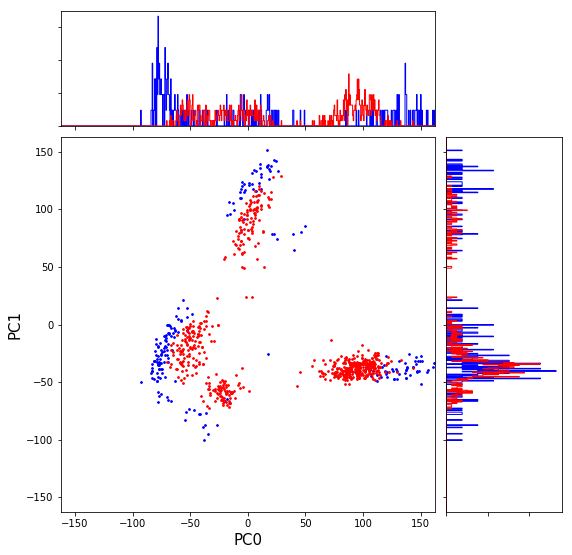

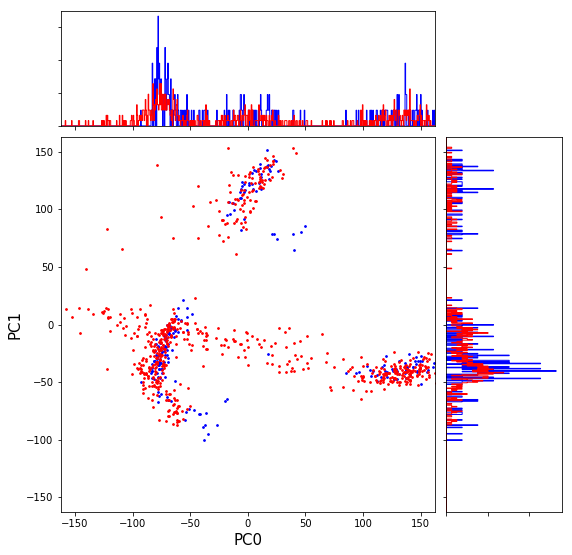

In [13]:
%matplotlib inline
calibratedSource = calibMMDNet.predict(source)

##################################### qualitative evaluation: PCA #####################################
pca = decomposition.PCA()
pca.fit(target)

# project data onto PCs
target_sample_pca = pca.transform(target)
projection_before = pca.transform(source)
projection_after = pca.transform(calibratedSource)

# choose PCs to plot
pc1 = 0
pc2 = 1
axis1 = 'PC'+str(pc1)
axis2 = 'PC'+str(pc2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_before[:,pc1], 
               projection_before[:,pc2], axis1, axis2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_after[:,pc1], 
               projection_after[:,pc2], axis1, axis2)

In [14]:
# df = pd.DataFrame(calibratedSource)
# df

In [15]:
# calibratedSourcePath = os.path.join(io.DeepLearningRoot(), 'data/calibratedBatch1-gtex-20PCs.csv')
# df.to_csv(calibratedSourcePath)